<a href="https://colab.research.google.com/github/shu65/blog-bayes-book/blob/main/%E3%83%99%E3%82%A4%E3%82%BA%E6%8E%A8%E5%AE%9A%E3%81%AB%E3%82%88%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E5%85%A5%E9%96%80%E3%80%805_7_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import math

import numpy as np
import torch

def f_true(X):
  return 0.5*torch.sin(2*math.pi * X[:, [0]]/3)

D=1
M=2

# viz data
xmin = -2
xmax = 4
N_lin = 1000
X_lin = torch.ones(N_lin, M)
X_lin[:, 0] = torch.linspace(xmin, xmax, N_lin)
X_lin[:, 1] = 1 # bias

# training data
N = 50 # data size
X = 2*torch.rand(N, M) # input
X[:, 1] = 1.0 # bias
Y = f_true(X) + 0.01 * torch.randn(N, 1)    
    
# model parameters
K = 5
sigma2_w = 10.0
sigma2_y = 0.01

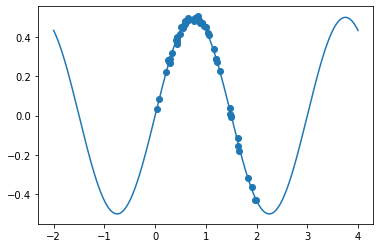

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X_lin[:, 0].numpy(), f_true(X_lin))
plt.scatter(X[:, 0].numpy(), Y[:, 0].numpy())

In [9]:
import torch
from torch import nn

class BayeNNModel(nn.Module):
    def __init__(self, M, K, D, sigma_w, sigma_y):
        super(BayeNNModel, self).__init__()
        self.M = M
        self.K = K
        self.D =D
        self.sigma_w = sigma_w
        self.sigma_y = sigma_y
        self.approximate_posterior_sigma_eps = 1e-8
        self.mu1 = torch.nn.parameter.Parameter(torch.randn(K, M))
        self.rho1 = torch.nn.parameter.Parameter(torch.randn(K, M))
        self.mu2 = torch.nn.parameter.Parameter(torch.randn(D, K))
        self.rho2 = torch.nn.parameter.Parameter(torch.randn(D, K))

    def rho2sigma(self, rho):
        return torch.log(1 + torch.exp(rho))

    def sample_W(self, mu, rho):
      eps = torch.randn(mu.shape)
      sigma = self.rho2sigma(rho) + self.approximate_posterior_sigma_eps
      W = mu + sigma * eps
      return W

    def forward(self, X):
      W1 = self.sample_W(self.mu1, self.rho1)
      h1 = torch.nn.functional.linear(X, W1, bias=None)
      h2 = torch.tanh(h1)
      W2 = self.sample_W(self.mu2, self.rho2)
      Y_est = torch.nn.functional.linear(h2, W2, bias=None)
      return Y_est, W1, W2

    def _compute_approximate_posterior_log_prob_core(self, W, mu, rho):
      sigma = self.rho2sigma(rho) + self.approximate_posterior_sigma_eps
      W_dist = torch.distributions.normal.Normal(mu, sigma)
      log_prob_W = W_dist.log_prob(W)
      sum_log_prob_W = torch.sum(log_prob_W)
      return sum_log_prob_W

    def _compute_prior_log_prob_core(self, W, sigma_w):
      W_dist = torch.distributions.normal.Normal(0, sigma_w)
      log_prob_W = W_dist.log_prob(W)
      sum_log_prob_W = torch.sum(log_prob_W)
      return sum_log_prob_W

    def compute_approximate_posterior_log_prob(self, W1, W2):
      log_prob_W1 = self._compute_approximate_posterior_log_prob_core(W1, self.mu1, self.rho1)
      log_prob_W2 = self._compute_approximate_posterior_log_prob_core(W2, self.mu2, self.rho2)
      return log_prob_W1 + log_prob_W2

    def compute_prior_log_prob(self, W1, W2):
      log_prob_W1 = self._compute_prior_log_prob_core(W1, self.sigma_w)
      log_prob_W2 = self._compute_prior_log_prob_core(W2, self.sigma_w)
      return log_prob_W1 + log_prob_W2

    def compute_log_prob_p(self, Y, Y_est):
      Y_dist = torch.distributions.normal.Normal(Y_est, self.sigma_y)
      log_p = Y_dist.log_prob(Y)
      return torch.sum(log_p)


def vi_step(X, Y, model, optimizer, N, max_grad_norm=1e2):
  model.zero_grad()

  batch_size = X.shape[0]
  Y_est, W1, W2 = model(X)
  prior_log_prob_W = model.compute_prior_log_prob(W1, W2)
  posterior_log_prob_W = model.compute_approximate_posterior_log_prob(W1, W2)
  log_prob_p = model.compute_log_prob_p(Y, Y_est)
  kl_divergence = batch_size/N * (posterior_log_prob_W - prior_log_prob_W) - log_prob_p

  kl_divergence.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
  optimizer.step()
  return kl_divergence.item()

In [10]:
dataset = torch.utils.data.TensorDataset(X, Y)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

gamma = 1.0e-4
max_iter = 100000

model = BayeNNModel(M, K, D, math.sqrt(sigma2_w), math.sqrt(sigma2_y))
optimizer = torch.optim.SGD(model.parameters(), lr=gamma)
kl_divergence_list = []

iter = 0
while iter < max_iter:
  for x, y in data_loader:
    kl_divergence = vi_step(x, y, model, optimizer, len(dataset))
    kl_divergence_list.append(kl_divergence)
    if (iter % 1000) == 0:
      print(f"{iter} iteration KL divergence: {kl_divergence}")
    iter += 1
    if iter >= max_iter:
      break

0 iteration KL divergence: 391.6127014160156
1000 iteration KL divergence: 0.20394879579544067
2000 iteration KL divergence: 70.76637268066406
3000 iteration KL divergence: 34.11581802368164
4000 iteration KL divergence: 25.70522689819336
5000 iteration KL divergence: 24.620159149169922
6000 iteration KL divergence: 2.6844582557678223
7000 iteration KL divergence: 5.146710395812988
8000 iteration KL divergence: -0.05410897731781006
9000 iteration KL divergence: 23.930007934570312
10000 iteration KL divergence: 24.907512664794922
11000 iteration KL divergence: 1.9995250701904297
12000 iteration KL divergence: 12.95975112915039
13000 iteration KL divergence: 8.418661117553711
14000 iteration KL divergence: 7.714238166809082
15000 iteration KL divergence: 3.433725357055664
16000 iteration KL divergence: 7.487505912780762
17000 iteration KL divergence: 6.024085998535156
18000 iteration KL divergence: 9.203699111938477
19000 iteration KL divergence: 3.5796594619750977
20000 iteration KL div

(-10.0, 100.0)

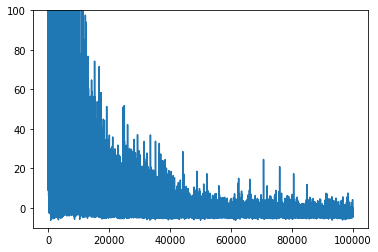

In [11]:
plt.plot(np.arange(len(kl_divergence_list)), kl_divergence_list)
plt.ylim(-10, 100)

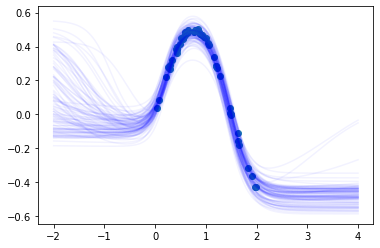

In [12]:
# viz
num_samples = 100
Y_est_samples = []
for _ in range(num_samples):
  Y_est, _, _ = model(X_lin)
  Y_est_samples.append(Y_est)

for Y_est in Y_est_samples:
  plt.plot(X_lin[:, 0].detach().cpu().numpy(), Y_est[:, 0].detach().cpu().numpy(), c="blue", alpha=0.05)
plt.scatter(X[:, 0].numpy(), Y[:, 0].numpy())